In [189]:
%pylab inline
from sshtunnel import SSHTunnelForwarder
import pymongo
import os
import stat
import json
import datetime
import paramiko
import pandas
import seaborn as sns

pkey=os.path.join(os.environ['HOME'],'.ssh/id_rsa')
key=paramiko.RSAKey.from_private_key_file(pkey)

MONGO_HOST = "129.94.162.112"
MONGO_USER = "goios"
MONGO_DB = "modal-2duct-simulations"
MONGO_COLLECTION = "modal-vt-bore-jumps"

local_port = 26017

# define ssh tunnel
with SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey=key,
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    connection = pymongo.MongoClient('localhost', local_port)
    db = connection[MONGO_DB]
    collection = db[MONGO_COLLECTION]
    
    connection.close()
    server.stop()

`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"



Populating the interactive namespace from numpy and matplotlib


In [229]:
with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]
        print(collection.count())
        print(json.dumps(db.command("dbstats"),indent=2))
#         for d in collection.find():
#             err = "Ok"
#             try:
#                 d['simulation']['error']
#                 err='Error in simulation'
#             except KeyError:
#                 pass
#             try:
#                 d['analysis']['error']
#                 err='Error in analysis'
#             except KeyError:
#                 pass
                
#             print(d['_id'],d['simulation']['start'],d['simulation']['end'],err)
        #ll = list(collection.find({'simulation.params.gamma.sustain_val': {'$gt':.4, '$lt':.65}}))
        #ll = list(collection.aggregate([ {'$match':{'simulation.params.gamma.sustain_val': {'$gt':.6, '$lt':.7}}}, { "$sample": { "size": 1000 } } ]))
        #ll = list(collection.find().sort([('simulation.start',-1)]).limit(1))
        #ll = list(collection.find({'$where':'analysis.pert_time < analysis.t_trans_start'}).sort([('simulation.start',-1)]).limit(1))
        ids = list(collection.aggregate( [{ '$project': { 
                                              'eq': { '$cond': [ { '$lt': [ '$analysis.pert_time', '$analysis.t_trans_start' ] }, 1, 0 ] } 
                                                     } },
                                         { '$match': { 'eq' : 1 } }, 
                                         { '$sort' : {'simulation.start': 1}},
                                         { '$limit' : 1},
                                         { "$group": {
                                                        "_id": "$_id",
                                                        "lastComment": { "$first": "$$CURRENT" }
                                                    }
                                                },
                                         { '$replaceRoot': { 'newRoot': '$lastComment' } }
                                            ]))
        ll = list(collection.find({'_id':ids[0]['_id']}))
    print(len(ll))

  # This is added back by InteractiveShellApp.init_path()



2718
{
  "db": "modal-2duct-simulations",
  "collections": 7,
  "views": 0,
  "objects": 154449,
  "avgObjSize": 3553.97470362385,
  "dataSize": 548907839.0,
  "storageSize": 320454656.0,
  "numExtents": 0,
  "indexes": 7,
  "indexSize": 2985984.0,
  "fsUsedSize": 26742026240.0,
  "fsTotalSize": 44780494848.0,
  "ok": 1.0
}
1


In [231]:
print(json.dumps(ll[0]['simulation'],indent=2,default=str))

{
  "start": "2020-10-26 16:46:54.029000",
  "params": {
    "description": "Reed simulation with modal tracts and reed dynamics and non-linear reed force var gamma",
    "version": "20201026",
    "db": "modal-vt-bore-jumps",
    "tmax": 0.5,
    "gamma": {
      "sustain_val": 0.559132863947976,
      "time_const": 0.05,
      "exp_limit_multiplier": 1.1
    },
    "zeta": 0.5,
    "reed": {
      "frequency": 574.4534242922867,
      "q": 4.617606048143152,
      "amplitude": 4.617606048143152
    },
    "bore": {
      "frequencies": [
        239.77755305798723
      ],
      "qs": [
        34.796094628275746
      ],
      "amplitudes": [
        34.796094628275746
      ]
    },
    "vocal": {
      "frequencies": [
        500
      ],
      "qs": [
        15
      ],
      "amplitudes": [
        15
      ]
    },
    "nlfunc": {
      "type": "parabolic",
      "nl_start": 0.75,
      "nl_ev": 1.1
    },
    "perturbation": {
      "multiplier": 1.1,
      "duration": 1.134

In [232]:
from random_single_mode_vt_bore_reed import ivp_simulate, do_analysis

def simulate_js(js):
    data = ivp_simulate(js)
    analysis = do_analysis(data, impedance=False)
 
    return data,analysis

In [233]:
from scipy.optimize import fmin

from functools import partial

def resonance(x,f=100,q=10,a=1):
    omegar=2*pi*f
    s = 1j*x*2*pi
    #fs = (a*omegar*q)**0*s**0/(s**2+s*omegar/q+omegar**2)
    fs = omegar*s/(s**2+s*omegar/q+omegar**2)
    return(np.abs(fs))

def impedance(x, fvec, qvec, avec):
    ret = 0*x
    for f, q, a in zip(fvec,qvec,avec):
        ret += resonance(x, f, q, a)
    return ret

fsrch = lambda x: -impedance(x, fvec, qvec, avec)

def impedance_info(row):
    zbore = partial(resonance,f=row['simulation/params/bore/frequencies/0'],
                              q=row['simulation/params/bore/qs/0'],
                              a=row['simulation/params/bore/amplitudes/0'])
    zvt = partial(resonance,f=row['simulation/params/vocal/frequencies/0'],
                              q=row['simulation/params/vocal/qs/0'],
                              a=row['simulation/params/vocal/amplitudes/0'])
    ztotal = lambda x: zbore(x)+zvt(x)
    zrat = lambda x: zbore(x)/zvt(x)
    zbore_max_f = fmin(lambda x: -zbore(x),row['simulation/params/bore/frequencies/0'],disp=False)[0]
    zbore_max = zbore(row['analysis/f0'])
    zrat_f0 = zrat(row['analysis/f0'])
    return pandas.Series({"zb_max_f":zbore_max_f,"zb_max_val":zbore_max,"zrat_f0":zrat_f0})



In [234]:
from json_object import JSONObject
row = JSONObject(ll[0])

In [235]:
import os
import numpy as np
from glob import glob
from pypevoc.Heterodyne import HeterodyneHarmonic
from pypevoc.PVAnalysis import PV
import timeseries as ts
import scipy.signal as sig

def db(x):
    return 20*np.log10(x)



In [236]:
import random
from json_object import JSONObject

#row = df[np.abs(-20*np.log10(df['zrat_f0'])-df['analysis/hrat1_abs_fin'])>5].sample().iloc[0]
#row = df[df['analysis/hrat1_abs_fin']<-20].sample().iloc[0]
# row = df1[df1['analysis/hrat1_abs_trans']-df1['analysis/hrat1_abs_fin']<-10].sample().iloc[0]
#row = df1.sample().iloc[0]
idx= 0
data,anal=simulate_js(JSONObject(ll[0]['simulation']['params']))

  frat = fx / self.oldfft

  frat = fx / self.oldfft

Traceback (most recent call last):
  File "/home/goios/Devel/vocalsims/projects/clarinet_vocal_tract/modal_simulations/simulation_harmonic_transient_analyser.py", line 222, in do_analysis
    rm=RANSACRegressor().fit(X,y)
  File "/home/goios/.pyenv/versions/unsw/lib/python3.7/site-packages/sklearn/linear_model/_ransac.py", line 282, in fit
    "of samples: n_samples = %d." % (X.shape[0]))
ValueError: `min_samples` may not be larger than number of samples: n_samples = 1.


768.0
768.0
768.0000000000002
768.0000000000002
767.9999999999999
768.0000000000003
768.0000000000003
768.0000000000003
768.0000000000003
768.0
768.0
768.0000000000002
768.0000000000002
767.9999999999999
768.0000000000003
768.0000000000003
768.0000000000003
768.0000000000003
Error in exponential estimation in b0
No transient found in vt0


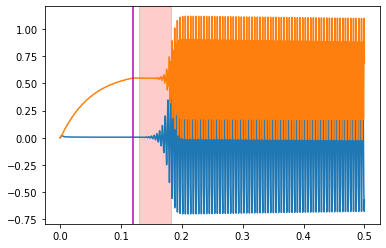

In [237]:
figure()
t = np.arange(len(data['p_b']))/data['js']['simulation']['sample rate']
plot(t,data['p_b'])
plot(t,data['p_vt']+data['p_blow'])
axvline(anal['pert_time'],color='m')
axvspan(anal['t_trans_start'],anal['t_trans_end'],color='r',alpha=.2)

In [238]:
row['analysis/f0']

228.01749498757192

In [239]:
t_init=[0.01,0.05]
t_fin=0.1
tsust=0.1

# extract main parameters
res = {}
sr = data['js']['simulation']['sample rate']
pb = data['p_b']
pvt = data['p_vt']
t = np.arange(len(pb))/sr
if data['pert_time']>0:
    res['pert_time']=data['pert_time']
else:
    res['pert_time'] = 0


pbinit = pb[int(t_init[0]*sr):int(t_init[1]*sr)]
res['initial amplitude'] = np.max(pbinit)-np.min(pbinit)
pbfin = pb[-int(t_fin*sr):]
res['final amplitude'] = np.max(pbfin)-np.min(pbfin) 

# fundamental frequency for harmonic analysis
pvpb = PV(pb,sr=sr,progress=False,nfft=1024*16,hop=512*2,pkthresh=1e-10)
pvpb.run_pv()
fts = ts.SampledTimeSeries(pvpb.fundamental_frequency, pvpb.t)

f0 = fts.percentile(50,from_time=fts.t[-1]-0.2)
if f0<20:
    f0 = np.median(fts.v[fts.v>0])
res['f0'] = f0
fw,pbw = sig.welch(pb,nperseg=2**10,nfft=2**12,fs=sr)

mainf = pvpb.f[np.arange(pvpb.f.shape[0]),np.argmin(np.abs(pvpb.f-f0),axis=1)]
mainfts = ts.SampledTimeSeries(mainf, pvpb.t)
mainfts.label = 'f0'

# harmonic analysis
try:
    nwind = int(sr/f0*3)
except ValueError:
    nwind = 1024


ha = {}
for lab in ('b', 'vt', 'm'):
    try:
        p = data['p_{}'.format(lab)]
    except KeyError:
        continue

    h = HeterodyneHarmonic(p,sr=sr,tf=[0,max(pvpb.t)],f=[f0,f0],nwind=nwind,nhop=128)
    h_array = [ts.SampledTimeSeries(np.abs(h.camp[:,ii]),h.t,label='h{}{}'.format(lab,ii+1)) for ii in range(h.camp.shape[1])]
    ha[lab] = h_array
    for ii, hts in enumerate(h_array):
        res['{}_t_min'.format(hts.label)]=hts.min_time()
        res['{}_t_max'.format(hts.label)]=hts.max_time()
        res['{}_abs_min'.format(hts.label)]=hts.min()
        res['{}_abs_max'.format(hts.label)]=hts.max()
        res['{}_abs_fin'.format(hts.label)]=hts.v[-1]
        if data['pert_time']>1e-4:
            res['{}_abs_pert'.format(hts.label)]=hts[data['pert_time']]
        else:
            res['{}_abs_pert'.format(hts.label)]=np.nan    

hts_array = ha['b']
vts_array = ha['vt']

# transient detection using one envelope
ats = hts_array[0]

amax = ats.max()

a_trans_end = amax*.7
a_trans_start = amax*.001
try:
    t_trans_end = ats.crossing_times(a_trans_end)[0][0]
except IndexError:
    t_trans_end = ats.v[-1]
try:
    t_trans_start = ats.crossing_times(a_trans_start,to_time=t_trans_end)[0][0]
except IndexError:
    t_trans_start = t_trans_end - ats.dt

atrans, ttrans = ats.apply(db).times_values_in_range(from_time=t_trans_start,to_time=t_trans_end)

# frequency comparison
fsusav = fts.mean(from_time=fts.t[-1]-tsust)
res['t_trans_start']=t_trans_start
res['t_trans_end']=t_trans_end
res['sus_f0_avg']=fts.mean(from_time=fts.t[-1]-tsust)
res['sus_f0_std']=fts.std(from_time=fts.t[-1]-tsust)
res['trans_f0_avg']=fts.mean(from_time=t_trans_start, to_time=t_trans_end)
res['trans_f0_std']=fts.std(from_time=t_trans_start, to_time=t_trans_end)

# harmonic descriptor extraction
for h_array in (hts_array,vts_array):
    for ii, hts in enumerate(h_array):
        res['{}_abs_sus'.format(hts.label)]=hts.percentile(50,from_time=fts.t[-1]-tsust)
        res['{}_abs_sus_var'.format(hts.label)]=np.diff(hts.percentile([75,25],from_time=fts.t[-1]-tsust))[0]
        res['{}_abs_trans'.format(hts.label)]=hts.percentile(50,from_time=t_trans_start, to_time=t_trans_end)
        res['{}_abs_trans_var'.format(hts.label)]=np.diff(hts.percentile([75,25],from_time=t_trans_start, to_time=t_trans_end))[0]

    # growth rate via derivative
    dts = hts.apply(db).diff()
    dts.label = hts.label
    for pct in [25,50,75]:
        res['{}_trans_rate_pct{}'.format(dts.label,pct)]=dts.percentile(pct,from_time=t_trans_start, to_time=t_trans_end)

    res['{}_abs_fin'.format(hts.label)]=hts.v[-1]
    if data['pert_time']>1e-4:
        res['{}_abs_pert'.format(hts.label)]=hts[data['pert_time']]
    else:
        res['{}_abs_pert'.format(hts.label)]=np.nan    

# harmonic ratio descriptors
for ii, hts in enumerate(hts_array):
    vts = vts_array[ii]
    rts = vts.apply(db)-hts.apply(db)
    rts.label = 'hrat{}'.format(ii+1)
    res['{}_abs_sus'.format(rts.label)]=rts.percentile(50,from_time=fts.t[-1]-tsust)
    res['{}_abs_sus_var'.format(rts.label)]=np.diff(rts.percentile([75,25],from_time=fts.t[-1]-tsust))[0]
    res['{}_abs_trans'.format(rts.label)]=rts.percentile(50,from_time=t_trans_start, to_time=t_trans_end)
    res['{}_abs_trans_var'.format(rts.label)]=np.diff(rts.percentile([75,25],from_time=t_trans_start, to_time=t_trans_end))[0]
    res['{}_abs_fin'.format(rts.label)]=rts.v[-1]
    if data['pert_time']>1e-4:
        res['{}_abs_pert'.format(rts.label)]=rts[data['pert_time']]
    else:
        res['{}_abs_pert'.format(rts.label)]=np.nan    



  frat = fx / self.oldfft

  frat = fx / self.oldfft



In [240]:
from pypevoc.Heterodyne import heterodyne

def heterodyne_corr(x,sr,f,maxwind=2**14,nhop=2**10,nper=3,dc_cut=50):
    #c1,_ = heterodyne(x,x,wind=np.hanning(nwind),hop=nhop)
    xx = x.copy()
#     newn = int(len(xx)/sr*dc_cut)
#     x2 = np.concatenate((xx,np.zeros(int((newn+1)*sr/dc_cut))))
#     print(newn,x2.shape)
#     xd = sig.resample(x2,newn)
#     xu = sig.resample(xd,len(x2))[:len(xx)]
#     xx -= xu
    t = np.arange(len(x))/sr
    #npts = len(c1)
    nharm = len(f)
    #camp = np.zeros((npts,nharm),dtype='complex')
    ret = []
    part = np.zeros((len(x),nharm))
    for ii,ff in enumerate(f):
        #nwind = int(min(maxwind,sr/ff*nper))
        if ff==0.:
            nwind=maxwind
        foth = np.delete(f,ii)
        nwind = (sr/np.min(np.abs(foth-ff))*nper)
        print(nwind)
        hetsig = np.exp(1j*2*np.pi*ff*t)
        cc,ih = heterodyne(xx,hetsig,wind=np.hanning(nwind),hop=nhop)
        if ff==0.:
            cc/=2
        th=ih/sr
        ret.append(ts.SampledTimeSeries(cc,th,label='%.2f'%ff))
        ret[-1].f = ff
        hf = np.interp(t,th,cc)
        xp = np.real(np.conjugate(hf)*hetsig)
        xx-=xp
        part[:,ii]=xp
    return ret,xx,part

def heterodyne_freq_corr(hh,f):
    return hh.v

[   0.          227.90205432  455.80410863  683.70616295  911.60821726
 1143.01645703 1370.91851134 1598.82056566 1826.72261997]
756.1846153846154
756.1846153846154
756.1846153846154
756.1846153846154
756.1846153846154
756.1846153846158
756.1846153846158
756.1846153846158
756.1846153846158
756.1846153846154
756.1846153846154
756.1846153846154
756.1846153846154
756.1846153846154
756.1846153846158
756.1846153846158
756.1846153846158
756.1846153846158


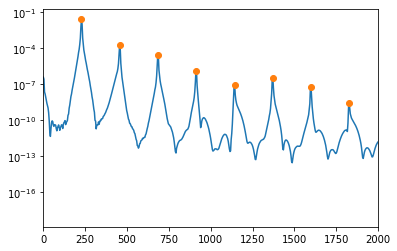

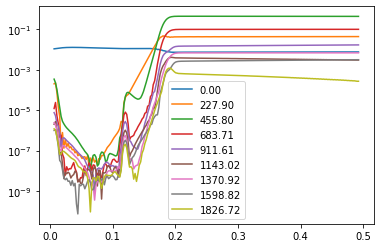

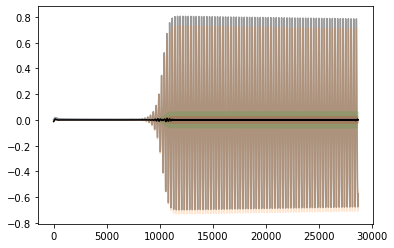

In [241]:
from scipy.signal import welch,find_peaks

fw,w=welch(pb,fs=sr,nperseg=2**14)

fig,ax=subplots(1)
semilogy(fw,w)
xlim(0,2000)

pks,_=find_peaks(10*np.log10(w),prominence=20)
ff=fw[pks]
ff=ff[(ff<2000)&(ff>100)]
nw=int(sr/np.min(ff)*6)
semilogy(fw[pks],w[pks],'o')

ff=np.insert(ff,0,0)

print(ff)

#nw=nwind
nw=2**16
nper=3
hetpb,pbresid,pbpart=heterodyne_corr(pb,sr,ff,maxwind=nw,nhop=128,nper=nper)
hetpv,pvresid,pvpart=heterodyne_corr(pvt,sr,ff,maxwind=nw,nhop=128,nper=nper)
fig,ax=subplots(1)
for tts in hetpv:
    ax.semilogy(tts.t,np.abs(tts.v),label=tts.label)
    
ax.legend()
ax.set_yscale('log')

figure()
plot(pb,color='k',alpha=.4)
plot(pbpart,alpha=.2)
plot(pbresid,color='k')

In [242]:
thr=.05
f0r = f0
for f in ff:
    if f==0:
        continue
    frat = f/f0r
    hno = np.round(frat)
    fdev = np.abs(frat-hno)
    print(f,frat,fdev,fdev<thr,hno)
    #if fdev<thr:
    #    f0r=np.mean([f0r,f/hno])
    

227.90205431517722 0.9990927746520378 0.0009072253479621706 True 1.0
455.80410863035445 1.9981855493040757 0.0018144506959243412 True 2.0
683.7061629455317 2.9972783239561136 0.0027216760438864007 True 3.0
911.6082172607089 3.9963710986081513 0.0036289013918486823 True 4.0
1143.016457026889 5.01083453133176 0.010834531331759933 True 5.0
1370.918511342066 6.009927305983797 0.009927305983796764 True 6.0
1598.8205656572434 7.009020080635835 0.00902008063583537 True 7.0
1826.7226199724205 8.008112855287873 0.008112855287873089 True 8.0


In [243]:
np.diff(fw)[0]

3.5061854510027266

In [244]:
f0r

228.10900058260407

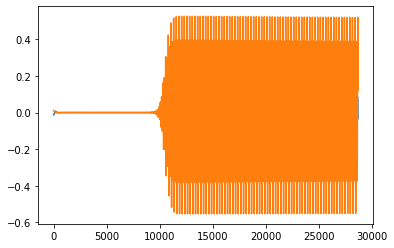

In [245]:
def semilogabsy(x,y,*args,**kwargs):
    return semilogy(x,np.abs(y),*args,**kwargs)
figure()
plot(np.arange(len(pb)),pb-np.sum(pbpart[:,0:2],axis=1))
plot(np.arange(len(pb)),pvt-np.sum(pvpart[:,0:2],axis=1))


228.10900058260407 227.90205431517722
0.2071186191405867 0.7303490294528281
0.046687858172386416 7.999917795593126e-08
0.18038015897922 0.0477754090316824
0.062285293266517 1.8044107324235193e-08


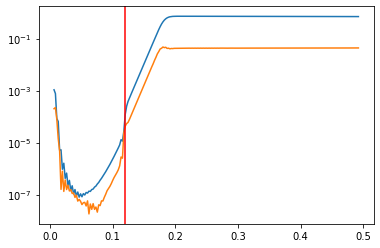

In [246]:
mainidx = np.argmin(np.abs(np.array(ff)-f0))
print( f0,ff[mainidx])
fig,ax=subplots(1)
plot(hetpb[mainidx].t,np.abs(hetpb[mainidx].v))
habs = hetpb[mainidx].apply(abs)
print (habs.max_time(),habs.max())
print (habs.min_time(),habs.min())
plot(hetpv[mainidx].t,np.abs(hetpv[mainidx].v))
habs = hetpv[mainidx].apply(abs)
print (habs.max_time(),habs.max())
print (habs.min_time(),habs.min())
ax.set_yscale('log')
ax.axvline(data['pert_time'],color='r')

In [247]:
pvt

array([-1.39764845e-04, -3.01279406e-04, -4.62894056e-04, ...,
        2.00356760e-01,  1.71853118e-01,  1.42717155e-01])

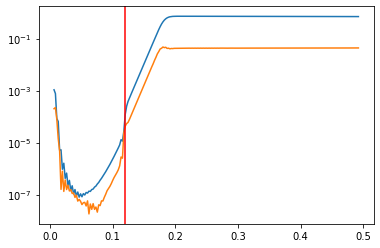

In [248]:
fig,ax=subplots(1)
hb = hetpb[mainidx].apply(np.abs)
hb.label = hetpb[mainidx].label
hb.plot(ax=ax)
hv = hetpv[mainidx].apply(np.abs)
hv.label = hetpv[mainidx].label
hv.plot(ax=ax)
ax.axvline(data['pert_time'],color='r')
ax.set_yscale('log')

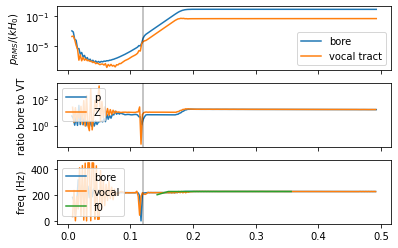

In [250]:

hh = hetpb[mainidx]
fbc=(hh.apply(np.angle).apply(np.unwrap).diff()/2/pi).apply(lambda x: hh.f-x)
fbc.label = 'bore'
hh = hetpv[mainidx]
fvc=(hh.apply(np.angle).apply(np.unwrap).diff()/2/pi).apply(lambda x: hh.f-x)
fvc.label = 'vocal'


fig,ax = plt.subplots(3,sharex=True)
hb1 = hb.copy()
hb1.f = float(hb.label)
hb1.label= 'bore'
hb1.plot(ax=ax[0])
hv1 = hv.copy()
hv1.f = float(hv.label)
hv1.label='vocal tract'
hv1.plot(ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_ylabel('$p_{RMS}/(k H_0)$')
ax[0].legend()
(hb1/hv1).plot(ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_ylabel('ratio bore to VT')
# zts = mainfts.apply(lambda x: impedance(x,fvec = [row['simulation/params/bore/frequencies/0']],
#          qvec = [row['simulation/params/bore/qs/0']],
#          avec=[row['simulation/params/bore/amplitudes/0']])/impedance(x,fvec = [row['simulation/params/vocal/frequencies/0']],
#          qvec = [row['simulation/params/vocal/qs/0']],
#          avec=[row['simulation/params/vocal/amplitudes/0']]))
zb =  fbc.apply(lambda x: impedance(x,fvec = [row['simulation/params/bore/frequencies/0']],
          qvec = [row['simulation/params/bore/qs/0']],
          avec=[row['simulation/params/bore/amplitudes/0']]))
zv =  fvc.apply(lambda x: impedance(x,fvec = [row['simulation/params/vocal/frequencies/0']],
          qvec = [row['simulation/params/vocal/qs/0']],
          avec=[row['simulation/params/vocal/amplitudes/0']]))
zts = zb/zv
zts.plot(ax=ax[1])
ax[1].legend(['p','Z'])


ax[2].set_ylabel('freq (Hz)')
fbc.plot(ax=ax[2])
fvc.plot(ax=ax[2])

mainfts.plot(ax=ax[2])

for axi in ax:
    axi.axvline(data['pert_time'],color='k',alpha=.3)
#ax[2].set_ylim(350,450)
ax[2].legend()

  mag = 20*np.log10(self.mag)



(0.0, 2000.0)

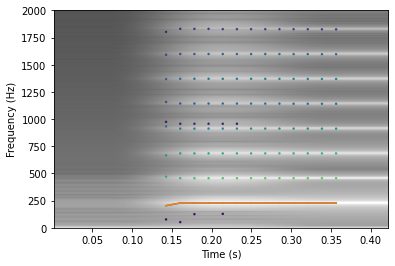

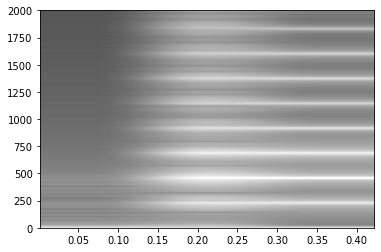

In [251]:
fig,ax = subplots(1)
ax.specgram(data['p_b'],Fs=sr,NFFT=2**13,cmap='gray')
pvpb.plot_time_freq(ax=ax)
ax.plot(pvpb.t,pvpb.fundamental_frequency)
ax.plot(pvpb.t,mainf)
ax.set_ylim(0,2000)
fig,ax = subplots(1)
ax.specgram(data['p_vt'],Fs=sr,NFFT=2**13,cmap='gray')
#pvpb.plot_time_freq(ax=ax)
# ax.plot(pvpb.t,pvpb.fundamental_frequency)
# ax.plot(pvpb.t,mainf)
ax.set_ylim(0,2000)

bore
0.14188464519649374 0.1781653540997356
-206.9161300658519 1115.7376815075309
0.11576221358925043 21.031191755961686
vocal tract
0.1350224911680355 0.17041679721771422
-225.59690906134244 1130.9992565564498
0.10907759854890875 18.712079321999084


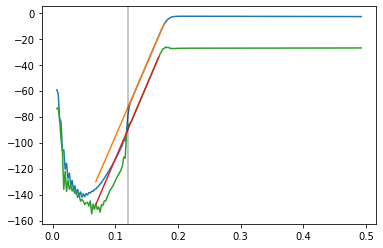

In [252]:
from sklearn.linear_model import RANSACRegressor
fig,ax=subplots(1)
for hh in [hb1,hv1]:
    print(hh.label)
    hbl1=hh.apply(db)
    vals=hbl1.percentile([5,99])
    ted=hbl1.crossing_times(vals[1]-6)[0][0]
    tst=hbl1.crossing_times(vals[1]-46,to_time=ted)[0][-1]
    print(tst,ted)
    x,y=hbl1.times_values_in_range(tst,ted)
    X = np.array([x]).T
    rm=RANSACRegressor().fit(X,y)
    print(rm.estimator_.intercept_,rm.estimator_.coef_[0])
    fig,ax=hbl1.plot(ax=ax)
    xpred,ytrue = hbl1.times_values_in_range(min(data['pert_time']-.05,tst),ted)
    if len(xpred)>0:
        Xpred = np.array([xpred]).T
        ypred = rm.predict(Xpred)
        ax.plot(xpred,ypred)
        print (xpred[np.argmax(ypred-ytrue)],np.max(ypred-ytrue))
    else:
        xpred=x
        Xpred = X
        ypred = rm.predict(Xpred)
        ax.plot(xpred,ypred)
ax.axvline(data['pert_time'],color='k',alpha=.3)
#ax.set_xlim(0,max(data['pert_time'],ted))